In [2]:
import numpy as np;
import matplotlib.pyplot as plt;

%matplotlib inline

In [3]:
class BezierCurve:
    def __init__(self, p0, p1, p2):
        '''
            Quadratic Bezier Curve Formulation
            in 2 dimensions
            
            Input:
            ------
                p0: 2x1 point
                p1: 2x1 point
                p2: 2x1 point
        '''
        self.p0 = p0
        self.p1 = p1
        self.p2 = p2
    def getPositions(self, t):
        '''
            Parameters:
            -----------
                t: N array where it represents the input to throw into Bezier Curve
            Returns:
            --------
                output: Nx2 array of positions where first row is x and second row is y
            
            Description:
            ------------
                Just plugging in the positional equation of Bezier Curve
        '''
        return (1-t)*( (1-t)*self.p0 + t*self.p1 ) + t*( (1-t)*self.p1 + t*self.p2 )
    def getDerivative(self, t):
        '''
            Parameters:
            -----------
                t: N array where it represents the input to throw into Bezier Curve
            Returns:
            --------
                output: Nx2 array of derivatives where first row is x and second row is y
            
            Description:
            ------------
                Just plugging in the derivative equation of Bezier Curve
        '''
        return 2*(1-t)*(self.p1-self.p0)+2*t*(self.p2-self.p1)
    def getDoubleDerivative(self, t):
        '''
            Parameters:
            -----------
                t: N array where it represents the input to throw into Bezier Curve
            Returns:
            --------
                output: Nx2 array of double derivatives where first row is x and second row is y
            
            Description:
            ------------
                Just plugging in the second derivative equation of Bezier Curve
        '''
        val = 2*(self.p2 - 2*self.p1 + self.p0)
        arr = np.zeros(shape=(2,t.shape[0]), dtype=float)
        arr[0,:] = val[0,:]
        arr[1,:] = val[1,:]
        return arr
    def getSpeed(self, t):
        '''
            Parameters:
            -----------
                t: N array where it represents the input to throw into Bezier Curve
            Returns:
            --------
                output: Nx1 array of general speed of the curve
            
            Description:
            ------------
                Plugging in Derivative and then taking its L2-norm
        '''
        derivatives = self.getDerivative(t)
        speed = np.linalg.norm(derivatives,axis=0)
        return speed
        
    def curvature(self, t):
        '''
            Parameters:
            -----------
                t: N array where it represents the input to throw into Bezier Curve
            Returns:
            --------
                output: Nx1 array of the curvature of the curve
            
            Description:
            ------------
                getting curvature using derivative and second derivative (must derive later)
        '''
        derivatives = self.getDerivative(t)
        derivatives_2 = self.getDoubleDerivative(t)
        #can vectorize please?
        curvature = []
        for i in range(t.shape[0]):
            mtx = np.vstack( (derivatives[:,i], derivatives_2[:,i]) ).T
            det = np.linalg.det(mtx)
            length = np.linalg.norm(derivatives[:,i])**3
            curvature.append( det/length )
        return np.array(curvature)
    
def getDifferentialDrive(speed, curvature, track_radius=1):
    '''
        Parameters:
        -----------
            speed: Nx1 array of speeds
            curvature: Nx1 array of corresponding curvatures
            track_radius: distance between wheels of differential drive robot
        Returns:
        --------
            returns the corresponding left and right wheel velocities of the robot.
            
        Description:
        ------------
            If we hold these equations to be true: (v_L + v_R) / 2 = speed
                                                   (v_R - v_L) / track_radius = angular velocity
                                                   angular_velocity = speed * track_radius
            then the following code is just combining those equations to get the respective
            left and right wheel velocities
    '''
    left_speed = speed * (2 - track_radius * curvature)/2
    right_speed = speed * (2 + track_radius * curvature) / 2
    return left_speed, right_speed
def angularVelocity(speed, curvature, track_radius=1):
    '''
        Multiply speed and curvature then you get angular velocity, ....
        i got lazy documenting....
    '''
    return speed*curvature

In [4]:
class DifferentialDrive:
    def __init__(self, p0, p1, p2, track_radius=1, system_cov=np.ones(2,dtype=float), \
                 wheel_cov=np.ones(2,dtype=float)):
        '''
            Simulating a Differential Drive on a robot
            
            Input:
            ------
                p0
                p1: represents 2nd point of bezier curve
                p2: represents 3rd point of bezier curve
                track_radius: float, represents the distance between left and right wheel of diff drive robot.
                system_cov: Nx1
                wheel_cov: Nx1
            
        '''
        
        self.bezier = BezierCurve(p0,p1,p2)
        self.tw = track_radius
        
        self.system_cov = system_cov
        self.wheel_cov = wheel_cov
    def getGTSpeed(self, t):
        return self.bezier.getSpeed(t)
    def getGTWheelSpeed(self, t):
        speed = self.bezier.getSpeed(t)
        curvature = self.bezier.curvature(t)
        
        Lspeed, Rspeed = getDifferentialDrive(speed, curvature, track_radius=self.tw)
        
        return Lspeed, Rspeed
    def getGTAngularVelocity(self, t):
        speed = self.bezier.getSpeed(t)
        curvature = self.bezier.curvature(t)        
        
        return angularVelocity(speed, curvature)
    def simulateState(self, t):
        speeds = self.getGTSpeed(t)
        angular = self.getGTAngularVelocity(t)
        stateGT = np.vstack((speeds,angular))
        randomize = np.random.normal(np.zeros(2), system_cov, size=(speeds.shape[0],2))
        randomized_state = stateGT + randomize.T
        return randomized_state
    def simulateSensor(self, t, simState):
        Ct = np.array([[1,-self.tw/2],
                       [1, self.tw/2]])
        randomize = np.random.normal(np.zeros(2), system_cov, size=(simState.shape[1],2))
        randomized_measurements = Ct @ simState + randomize.T
        return randomized_measurements
    

In [5]:
p0 = np.array([[0,0]]).T
p1 = np.array([[3,0]]).T
p2 = np.array([[-5,-5]]).T

system_cov = np.array([1,1])
wheel_cov = np.array([1,1])
t = np.linspace(0,1,100)
drive = DifferentialDrive(p0,p1,p2,system_cov=system_cov, wheel_cov=wheel_cov)

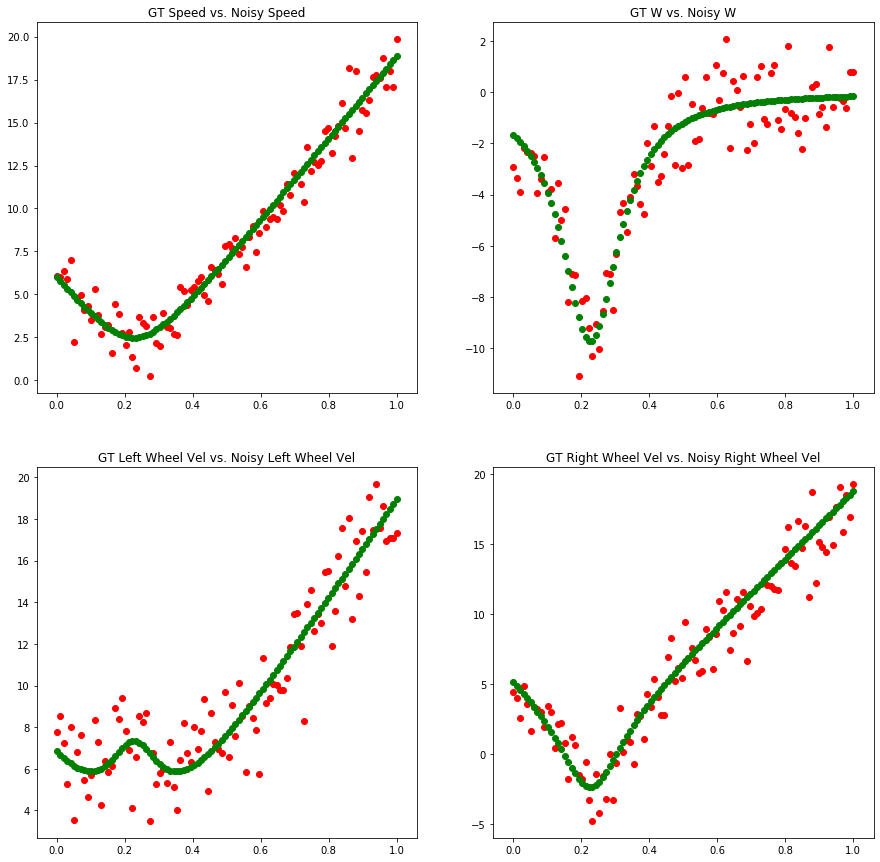

In [6]:
sim_state = drive.simulateState(t)
sim_speed = sim_state[0,:]
sim_w = sim_state[1,:]

sim_measurements = drive.simulateSensor(t, sim_state)
sim_meas_vl = sim_measurements[0,:]
sim_meas_vr = sim_measurements[1,:]

gt_meas_vl, gt_meas_vr = drive.getGTWheelSpeed(t)


plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title('GT Speed vs. Noisy Speed')
plt.scatter(t,sim_speed,color='r')
plt.scatter(t,drive.getGTSpeed(t),color='g')

plt.subplot(2,2,2)
plt.title('GT W vs. Noisy W')
plt.scatter(t,sim_w, color='r')
plt.scatter(t,drive.getGTAngularVelocity(t),color='g')


plt.subplot(2,2,3)
plt.title('GT Left Wheel Vel vs. Noisy Left Wheel Vel')
plt.scatter(t, sim_meas_vl, color='r')
plt.scatter(t, gt_meas_vl,color='g')

plt.subplot(2,2,4)
plt.title('GT Right Wheel Vel vs. Noisy Right Wheel Vel')
plt.scatter(t, sim_meas_vr,color='r')
plt.scatter(t, gt_meas_vr, color='g')

plt.show()

In [7]:
class Kalman_Filter:
    def __init__(self, prior, A, C, Q, R):
        '''
        
        '''
        self.prior = prior
        self.A = A
        self.C = C
        
        self.Q = Q # system cov
        self.R = R # meas cov
        
        self.prior = prior
        
        self.mean = prior
        self.cov = np.array([[0,0], [0,0]])
        
        self.Kalman_gain = None
        self.mean_predict = None
        self.cov_predict = None
        
    def predict(self):
        self.mean_predict = self.A @ prior
        self.cov_predict = self.A @ self.cov @ self.A.T + self.R
        
        self.Kalman_gain = self.cov_predict @ self.C.T @ np.linalg.inv( C @ self.cov_predict @ self.C.T + self.Q )
        
    def update(self, measurement):
        shape = self.Kalman_gain.shape[0]
        self.mean = self.mean_predict + self.Kalman_gain @ (measurement.reshape(shape,1) - (self.C @ self.mean_predict))
        self.cov = (np.eye(shape,dtype=float) - self.Kalman_gain@self.C) @ self.cov_predict
        
    def currState(self):
        return self.mean, self.cov
    
    def getPredictions(self, measurements):
        shape = self.cov.shape[0]
        
        states = np.zeros(shape=(shape, measurements.shape[1]),dtype=float)
        states[:,0] = self.prior.reshape(-1)
        for i in range(1,measurements.shape[1]):
            self.predict()
            self.update( measurements[:,i] )
            states[:,i] = kf.currState()[0].reshape(-1)
        
        return states

In [8]:
#setup simulation
p0 = np.array([[0,0]]).T
p1 = np.array([[3,0]]).T
p2 = np.array([[-5,-5]]).T

system_cov = np.array([1,1])
wheel_cov = np.array([1,1])

track_width = 10
t = np.linspace(0,1,100)
drive = DifferentialDrive(p0,p1,p2,system_cov=system_cov, wheel_cov=wheel_cov, track_radius=track_width)

#setup ground truth
gt_speed = drive.getGTSpeed(t)
gt_omega = drive.getGTAngularVelocity(t)
gt_state = np.vstack((gt_speed,gt_omega))

#setup simulation
sim_state = drive.simulateState(t)
sim_measurements = drive.simulateSensor(t, sim_state)


#setup kalman filter
prior = np.array([[gt_speed[0], gt_omega[0]]]).T
A = np.eye(2,dtype=float)
C = np.array([[1,-track_width/2],
                [1, track_width/2]])
Q = np.array([[0.1,0], [0,0.1]])
R = np.array([[3,0], [0,3]])

kf = Kalman_Filter(prior,A,C,Q,R)

In [9]:
v - wT/2 = left_vel
v + wT/2 = right_vel


1 - wT/2 [v] = [left_vel]
1 + wT/2 [w] = [right_vel]

SyntaxError: cannot assign to operator (2494480796.py, line 1)

In [ ]:
C^-1 (measurement) = noisy state

C^-1 (measurement - noise)

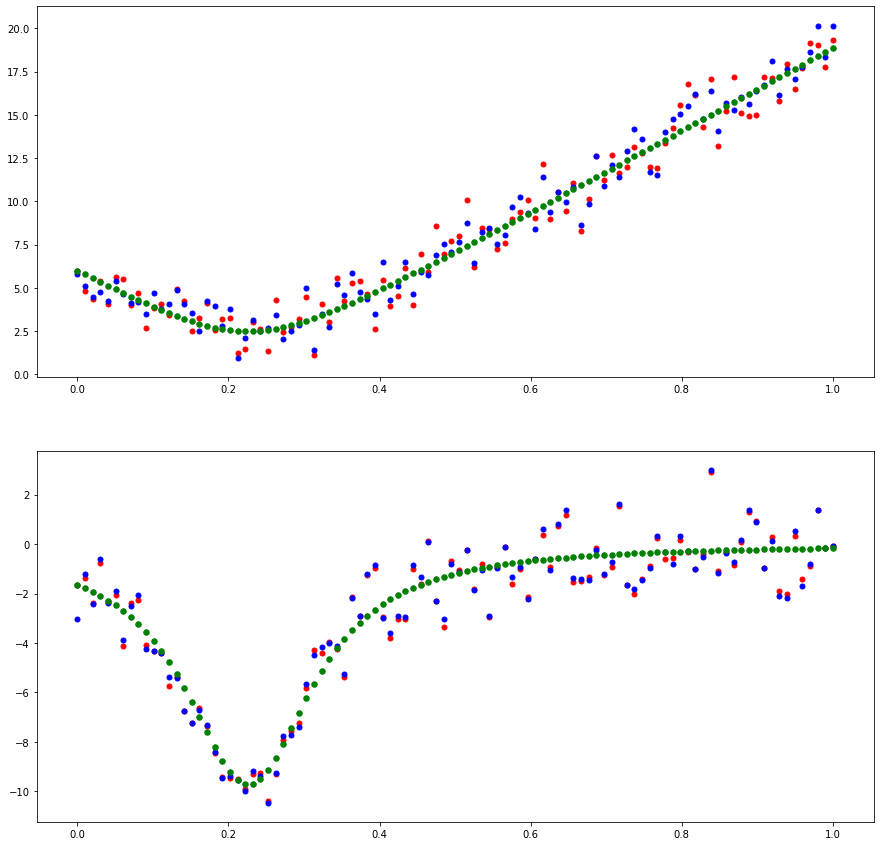

In [12]:
yhat = kf.getPredictions(sim_measurements)
plt.figure(figsize=(15, 15))

plt.subplot(2,1,1)
plt.scatter(t,yhat[0,:], color='r', s = 25)
plt.scatter(t,sim_state[0,:], color='b', s = 25)
plt.scatter(t, gt_state[0,:], color='g', s = 30)


plt.subplot(2,1,2)
plt.scatter(t,yhat[1,:], color='r', s = 25)
plt.scatter(t,sim_state[1,:], color='b', s = 25)
plt.scatter(t, gt_state[1,:], color='g', s = 30)

plt.show()